#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# conda install catboost

In [2]:
# conda install catboost --upgrade

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import cross_validate
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor

In [4]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.to_csv('taxi.csv', index=False)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
print(data.index.is_monotonic)

True


## Анализ

In [7]:
data = data.resample('1H').sum()
data.head()
print(data.index.min(), data.index.max())

2018-03-01 00:00:00 2018-08-31 23:00:00


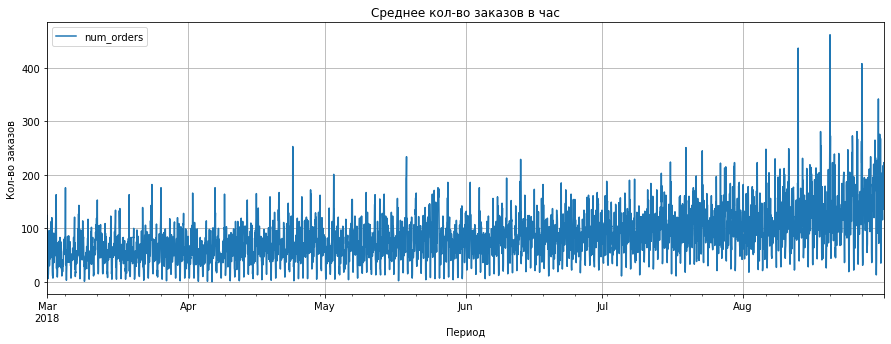

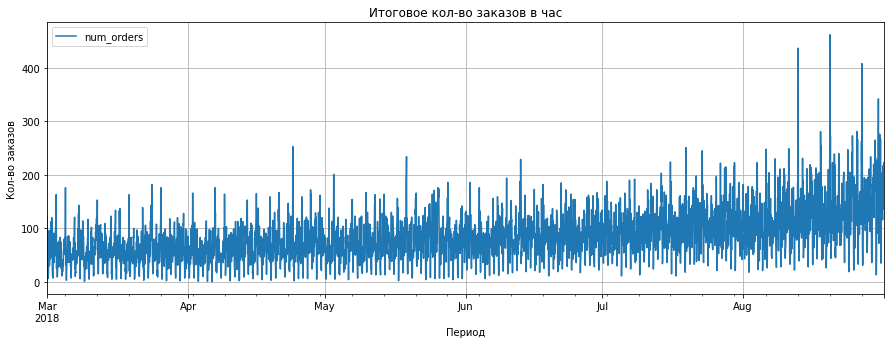

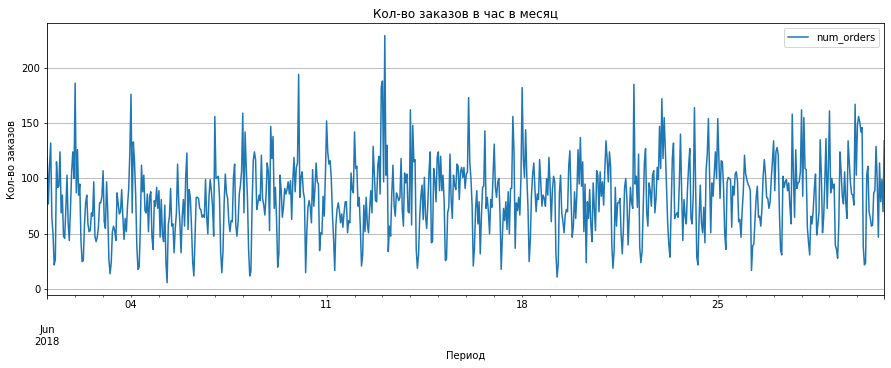

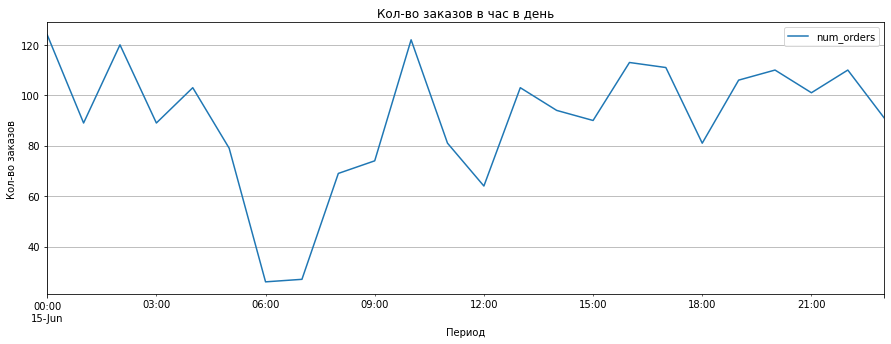

In [8]:
data.resample('1H').mean().plot(figsize = (15,5), grid=True)
plt.title('Среднее кол-во заказов в час')
plt.xlabel('Период')
plt.ylabel('Кол-во заказов')
plt.show()
data.resample('1H').sum().plot(figsize = (15,5), grid=True)
plt.title('Итоговое кол-во заказов в час')
plt.xlabel('Период')
plt.ylabel('Кол-во заказов')
plt.show()
data['2018-06':'2018-06'].resample('1H').sum().plot(figsize = (15,5), grid=True)
plt.title('Кол-во заказов в час в месяц')
plt.xlabel('Период')
plt.ylabel('Кол-во заказов')
plt.show()
data['2018-06-15':'2018-06-15'].resample('1H').sum().plot(figsize = (15,5), grid=True)
plt.title('Кол-во заказов в час в день')
plt.xlabel('Период')
plt.ylabel('Кол-во заказов')
plt.show()

В разрезе полугода можно сказать что в июле и августе заказов в среднем больше.

В разрезе месяца плюс минус ситуация с заказами стабильная.

В разрезе дня видно что есть сильный спад заказов с 6 утра до 7-8 утра.

In [9]:
data['rolling_mean'] = data.rolling(10).mean()

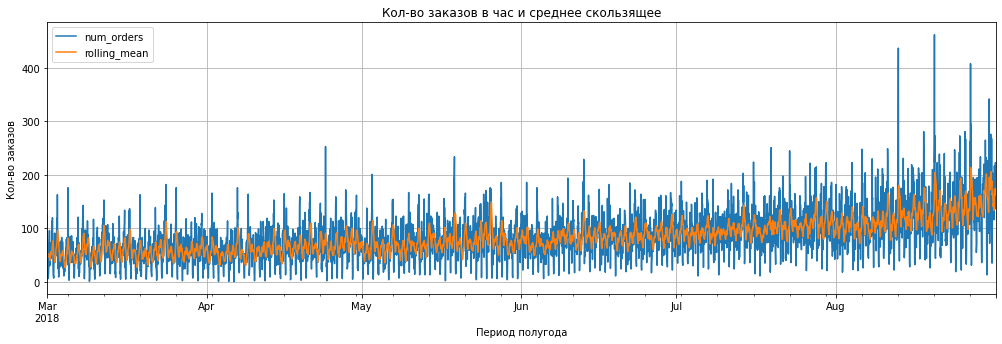

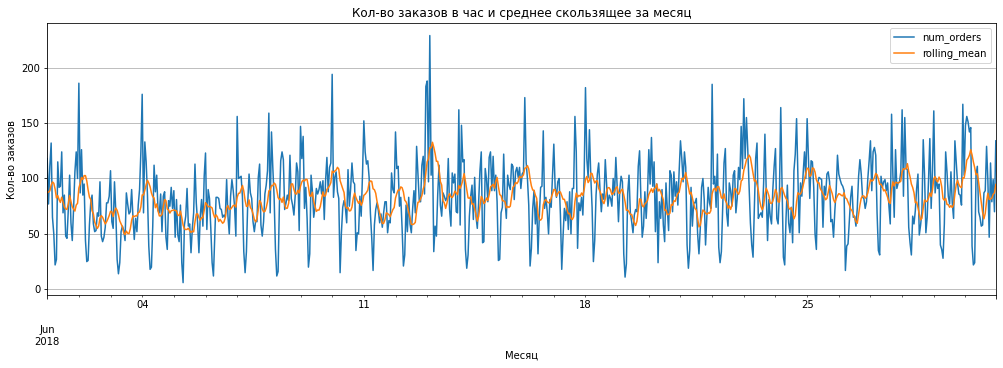

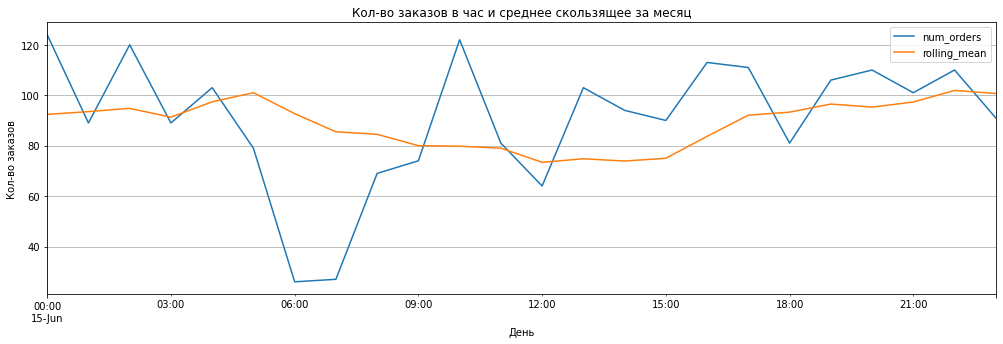

In [10]:
data.plot(figsize = (17,5), grid=True)
plt.title('Кол-во заказов в час и среднее скользящее')
plt.xlabel('Период полугода')
plt.ylabel('Кол-во заказов')
plt.show()
data['2018-06':'2018-06'].plot(figsize = (17,5), grid=True)
plt.title('Кол-во заказов в час и среднее скользящее за месяц')
plt.xlabel('Месяц')
plt.ylabel('Кол-во заказов')
plt.show()
data['2018-06-15':'2018-06-15'].plot(figsize = (17,5), grid=True)
plt.title('Кол-во заказов в час и среднее скользящее за месяц')
plt.xlabel('День')
plt.ylabel('Кол-во заказов')
plt.show()

По полугоду и по месяцу итог такой же.
А вот в разрезе дня видим что спад заказов идет примерно с 6 утра до 15 часов дня.

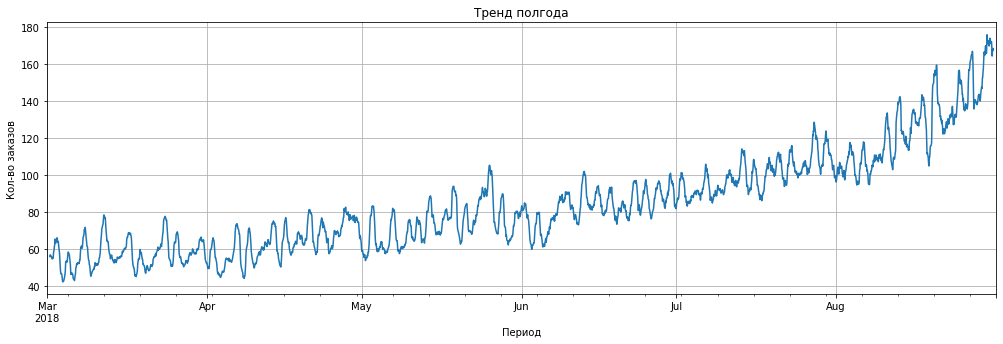

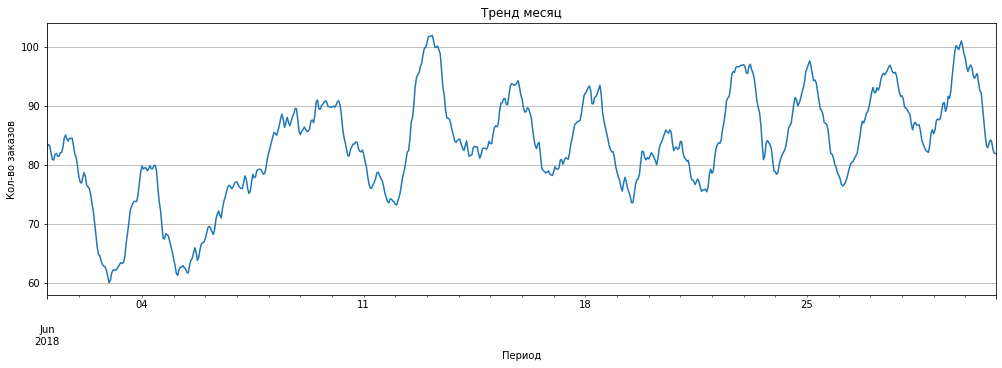

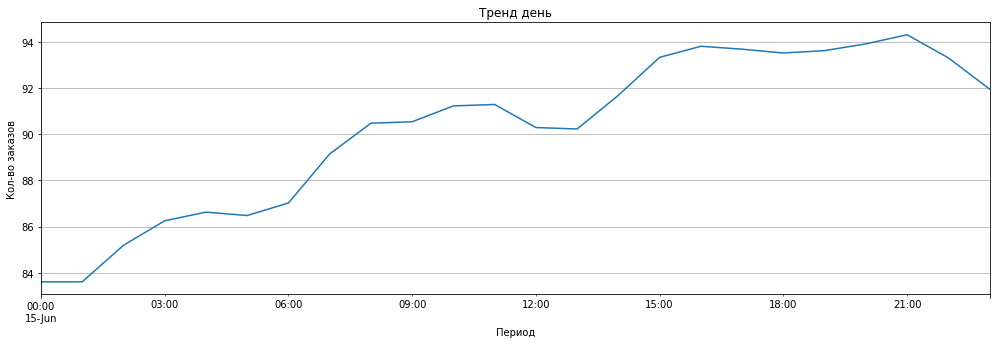

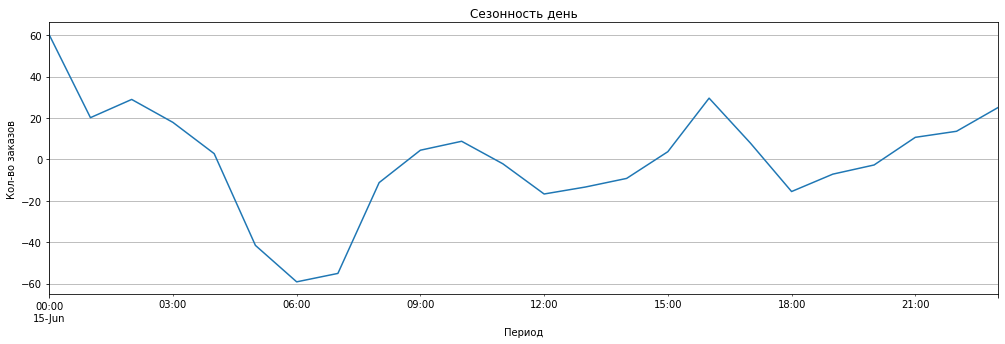

In [11]:
decomposed = seasonal_decompose(data['num_orders'])
decomposed.trend.plot(figsize = (17,5), grid=True)
plt.title('Тренд полгода')
plt.xlabel('Период')
plt.ylabel('Кол-во заказов')
plt.show()
decomposed.trend['2018-06':'2018-06'].plot(figsize = (17,5), grid=True)
plt.title('Тренд месяц')
plt.xlabel('Период')
plt.ylabel('Кол-во заказов')
plt.show()
decomposed.trend['2018-06-15':'2018-06-15'].plot(figsize = (17,5), grid=True)
plt.title('Тренд день')
plt.xlabel('Период')
plt.ylabel('Кол-во заказов')
plt.show()
decomposed.seasonal['2018-06-15':'2018-06-15'].plot(figsize = (17,5), grid=True)
plt.title('Сезонность день')
plt.xlabel('Период')
plt.ylabel('Кол-во заказов')
plt.show()

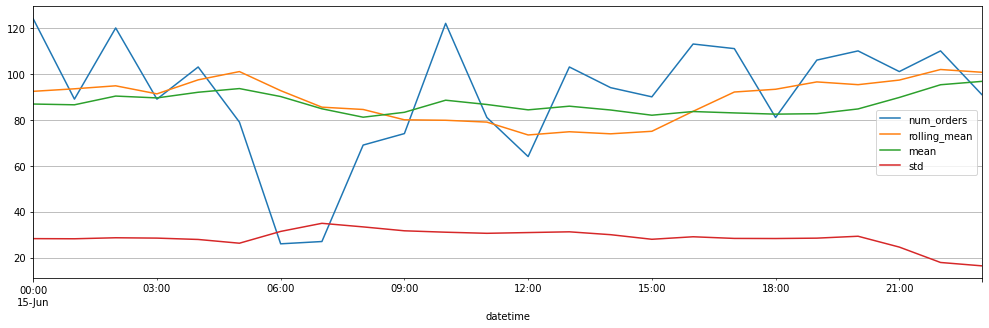

In [12]:
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data['2018-06-15':'2018-06-15'].plot(figsize = (17,5), grid=True)
plt.show()

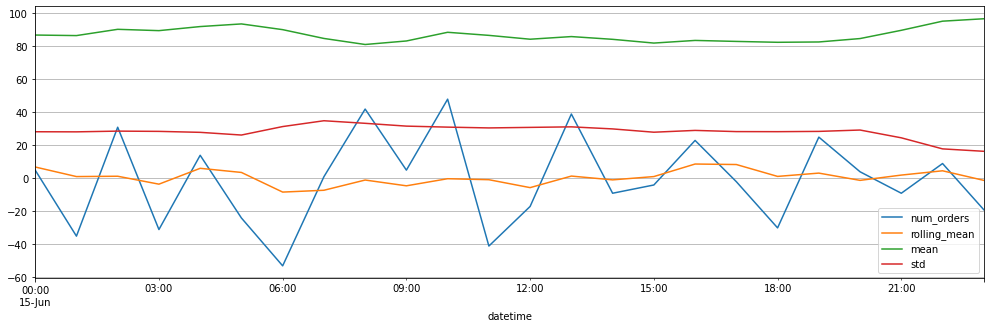

In [13]:
data_std = data - data.shift()
data_std['mean'] = data['num_orders'].rolling(15).mean()
data_std['std'] = data['num_orders'].rolling(15).std()
data_std['2018-06-15':'2018-06-15'].plot(figsize = (17,5), grid=True)
plt.show()

In [14]:
data = data.drop(['rolling_mean', 'mean', 'std'], axis=1)

## Обучение

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data_make = data.copy()
    data_make['day'] = data_make.index.day
    data_make['dayofweek'] = data_make.index.dayofweek
    data_make['hour'] = data_make.index.hour
    
    for lag in range(1, max_lag + 1):
        data_make['lag_{}'.format(lag)] = data_make['num_orders'].shift(lag)

    data_make['rolling_mean'] = data_make['num_orders'].shift().rolling(rolling_mean_size).mean()   
    return data_make

### Линейная регрессия

In [16]:
%%time
best_model = None
best_result = 200
for max_lag in range(1, 60, 5):
    for rolling_mean_size in range(1, 60, 5):
        make_features(data, max_lag, rolling_mean_size)
        train_l, test_l = train_test_split(data, shuffle=False, test_size=0.1)
        train_l = train_l.dropna()
        features_train_l = train_l.drop(['num_orders'], axis=1)
        target_train_l = train_l['num_orders']
        model_l = LinearRegression()
        scoring = 'neg_mean_squared_error'
        tscv = TimeSeriesSplit(n_splits=3)
        scores = cross_validate(model_l, features_train_l, target_train_l, cv=tscv,
                         scoring=('neg_root_mean_squared_error'),
                         return_train_score=True)
        result = scores['test_score'].mean()
        if result < best_result:
            best_model = model_l
            best_result = result
print(f'RMSE: {best_result:.2f}; lag: {max_lag}; rolling: {rolling_mean_size}')

RMSE: -34.30; lag: 56; rolling: 56
CPU times: user 25.9 s, sys: 55.5 s, total: 1min 21s
Wall time: 1min 21s


### CatBoost

In [17]:
%%time
make_features(data, 49, 49)
train_cat, test_cat = train_test_split(data, shuffle=False, test_size=0.1)
train_cat = train_cat.dropna()
features_train_cat = train_cat.drop(['num_orders'], axis=1)
target_train_cat = train_cat['num_orders']
model_cat = CatBoostRegressor(n_estimators = 200, loss_function = 'RMSE', eval_metric = 'RMSE')
tscv = TimeSeriesSplit(n_splits=5)
result = cross_val_score(model_cat, features_train_cat, target_train_cat, cv=tscv,
                    scoring = 'neg_root_mean_squared_error').mean()

print(f'RMSE: {result:.2f}')

Learning rate set to 0.141644
0:	learn: 27.4300361	total: 59.2ms	remaining: 11.8s
1:	learn: 25.8040394	total: 68.6ms	remaining: 6.79s
2:	learn: 24.4676042	total: 79.1ms	remaining: 5.19s
3:	learn: 23.4622259	total: 88.3ms	remaining: 4.32s
4:	learn: 22.5658066	total: 98.3ms	remaining: 3.83s
5:	learn: 21.7230591	total: 108ms	remaining: 3.48s
6:	learn: 21.0120694	total: 118ms	remaining: 3.27s
7:	learn: 20.4302146	total: 127ms	remaining: 3.05s
8:	learn: 19.8293896	total: 136ms	remaining: 2.88s
9:	learn: 19.3192426	total: 144ms	remaining: 2.73s
10:	learn: 18.7548738	total: 152ms	remaining: 2.61s
11:	learn: 18.3999245	total: 161ms	remaining: 2.52s
12:	learn: 18.0203933	total: 169ms	remaining: 2.43s
13:	learn: 17.7814301	total: 177ms	remaining: 2.36s
14:	learn: 17.3950861	total: 185ms	remaining: 2.28s
15:	learn: 17.0602433	total: 193ms	remaining: 2.22s
16:	learn: 16.7760850	total: 201ms	remaining: 2.16s
17:	learn: 16.5855658	total: 209ms	remaining: 2.11s
18:	learn: 16.2967185	total: 216ms	rema

Линейная регрессия: RMSE 34.30
CatBoost: RMSE 24.05

Проверим на тесте CatBoost

## Тестирование

In [18]:
make_features(data, 56, 56)

,num_orders,day,dayofweek,hour,lag_1,rolling_mean,lag_2,lag_3,lag_4,lag_5,...,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,NaN,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,NaN,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,NaN,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,19,207.0,170.392857,217.0,197.0,116.0,133.0,...,191.0,169.0,120.0,159.0,220.0,163.0,196.0,135.0,167.0,179.0
2018-08-31 20:00:00,154,31,4,20,136.0,169.625000,207.0,217.0,197.0,116.0,...,170.0,191.0,169.0,120.0,159.0,220.0,163.0,196.0,135.0,167.0
2018-08-31 21:00:00,159,31,4,21,154.0,169.392857,136.0,207.0,217.0,197.0,...,177.0,170.0,191.0,169.0,120.0,159.0,220.0,163.0,196.0,135.0


In [19]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
print(train.shape, test.shape)
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

(3918, 61) (442, 61)
2018-03-03 08:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [20]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [21]:
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
print(features_test.shape, target_test.shape)

(442, 60) (442,)


In [22]:
model = CatBoostRegressor(n_estimators = 200, loss_function = 'RMSE', eval_metric = 'RMSE')
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print(f'RMSE:{mean_squared_error(target_test, predictions)**0.5:.2f}')

Learning rate set to 0.187995
0:	learn: 35.4862207	total: 13.8ms	remaining: 2.74s
1:	learn: 32.7183860	total: 30.6ms	remaining: 3.03s
2:	learn: 30.8422955	total: 44.5ms	remaining: 2.92s
3:	learn: 29.2165142	total: 60.2ms	remaining: 2.95s
4:	learn: 27.6910873	total: 75.7ms	remaining: 2.95s
5:	learn: 26.6602207	total: 88.7ms	remaining: 2.87s
6:	learn: 25.7990304	total: 102ms	remaining: 2.82s
7:	learn: 25.1725311	total: 116ms	remaining: 2.78s
8:	learn: 24.5866013	total: 130ms	remaining: 2.76s
9:	learn: 24.1287472	total: 145ms	remaining: 2.75s
10:	learn: 23.8011867	total: 159ms	remaining: 2.73s
11:	learn: 23.5156258	total: 175ms	remaining: 2.73s
12:	learn: 23.2649016	total: 188ms	remaining: 2.71s
13:	learn: 23.1348828	total: 202ms	remaining: 2.68s
14:	learn: 22.9080345	total: 217ms	remaining: 2.68s
15:	learn: 22.7512137	total: 233ms	remaining: 2.68s
16:	learn: 22.6028633	total: 247ms	remaining: 2.65s
17:	learn: 22.4086532	total: 259ms	remaining: 2.62s
18:	learn: 22.2397765	total: 272ms	rem

Полученная RMSE 39.11

In [23]:
predicted = pd.Series(list(predictions), index = target_test.index)

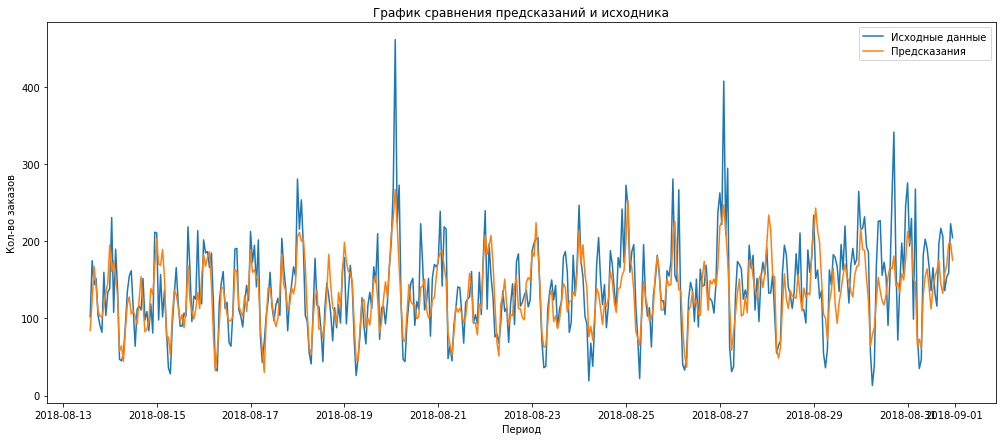

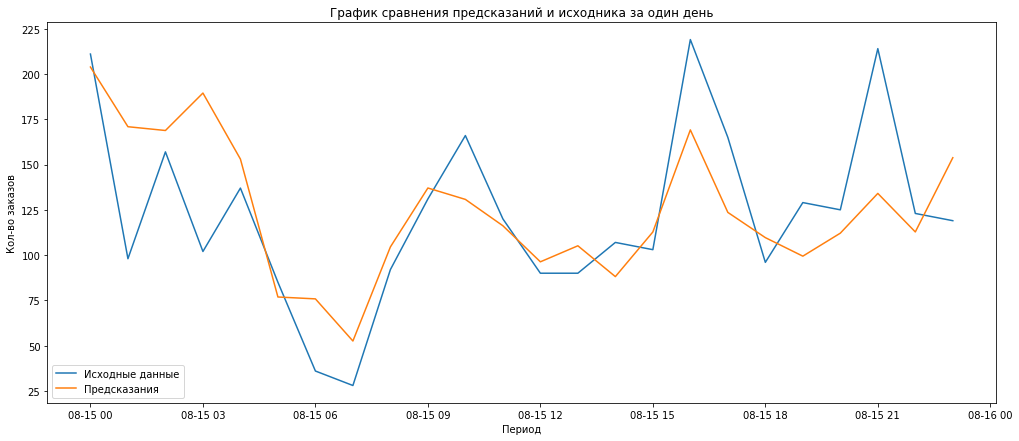

In [28]:
plt.figure(figsize=(17,7))
plt.plot(target_test, label='Исходные данные')
plt.plot(predicted, label='Предсказания')
plt.title('График сравнения предсказаний и исходника')
plt.xlabel('Период')
plt.ylabel('Кол-во заказов')
plt.legend()
plt.show()
plt.figure(figsize=(17,7))
plt.plot(target_test['2018-08-15':'2018-08-15'] , label='Исходные данные')
plt.plot(predicted['2018-08-15':'2018-08-15'], label='Предсказания')
plt.title('График сравнения предсказаний и исходника за один день')
plt.xlabel('Период')
plt.ylabel('Кол-во заказов')
plt.legend()

Как мы видим предсказания получились достаточно близкими к исходным данным..